## Importing Required libraries

In [33]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F
import time
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from torch.optim.lr_scheduler import StepLR
from collections import Counter

## Loading and  the Dataset

In [23]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = datasets.ImageFolder(root='datasets/cnn_dataset/cnn_dataset', transform=transform)
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Analysing and Visualizing dataset

In [25]:
pixel_sum = 0.0
pixel_squared_sum = 0.0
num_batches = 0

for images, _ in data_loader:
    pixel_sum += images.sum()
    pixel_squared_sum += (images ** 2).sum()
    num_batches += images.size(0)

num_pixels = num_batches * images.size(2) * images.size(3) * images.size(1)

mean = pixel_sum / num_pixels
std = (pixel_squared_sum / num_pixels - mean ** 2) ** 0.5

print(f"Total number of pixels: {num_pixels:.4f}")
print(f"Mean of pixel intensities: {mean.item():.4f}")
print(f"Standard deviation of pixel intensities: {std.item():.4f}")


Total number of pixels: 47624080.0000
Mean of pixel intensities: -0.6537
Standard deviation of pixel intensities: 0.6635


In [26]:
class_counts = Counter([label for _, label in dataset])
class_names = dataset.classes

for class_name, count in zip(class_names, class_counts.values()):
    print(f"Class '{class_name}' has {count} samples.")

Class '0' has 2800 samples.
Class '1' has 2800 samples.
Class '2' has 2800 samples.
Class '3' has 2800 samples.
Class '4' has 2800 samples.
Class '5' has 2800 samples.
Class '6' has 2800 samples.
Class '7' has 2800 samples.
Class '8' has 2800 samples.
Class '9' has 2800 samples.
Class 'A' has 2800 samples.
Class 'B' has 2800 samples.
Class 'C' has 2800 samples.
Class 'D' has 2800 samples.
Class 'E' has 2800 samples.
Class 'F' has 2800 samples.
Class 'G' has 2800 samples.
Class 'H' has 2800 samples.
Class 'I' has 2800 samples.
Class 'J' has 2800 samples.
Class 'K' has 2800 samples.
Class 'L' has 1945 samples.


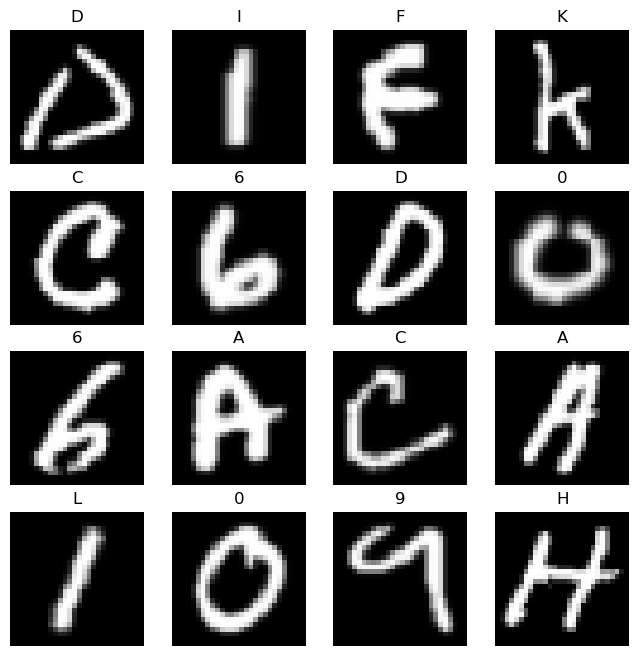

In [4]:
data_iter = iter(data_loader)
images, labels = next(data_iter)

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  
    plt.title(dataset.classes[labels[i]]) 
    plt.axis('off') 
plt.show()


### a) Class Distribution Bar Plot

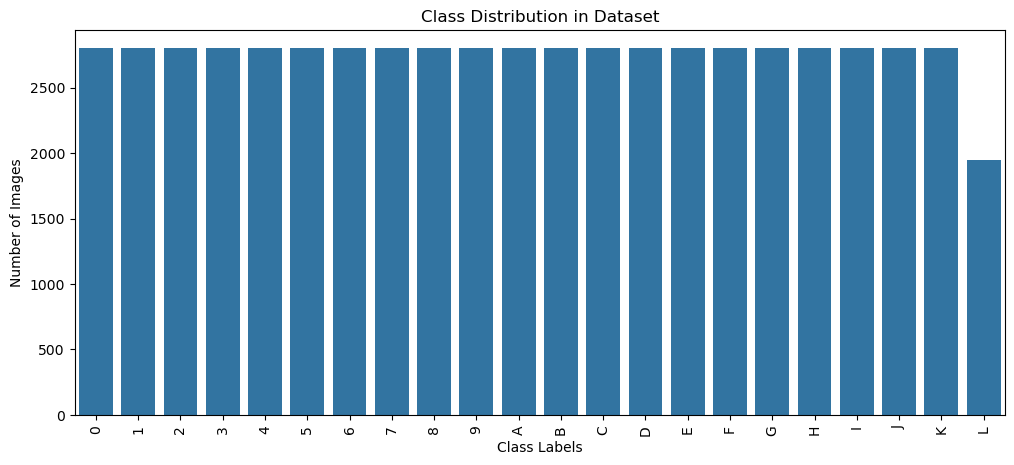

In [28]:
plt.figure(figsize=(12, 5))
sns.barplot(x=class_names, y=class_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Dataset")
plt.show()

### b) Pixel Intensity Histogram

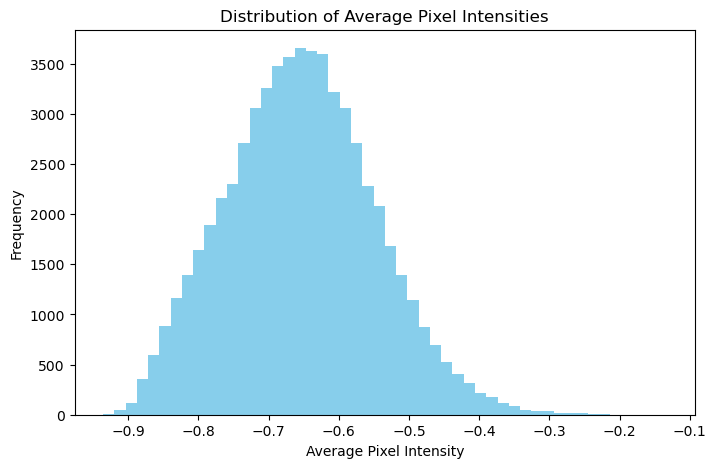

In [29]:
all_pixel_values = [image[0].mean().item() for image in dataset]  # assuming grayscale images for simplicity
plt.figure(figsize=(8, 5))
plt.hist(all_pixel_values, bins=50, color='skyblue')
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Average Pixel Intensities")
plt.show()

### c) Scatter Plot of Average Pixel Intensity vs. Pixel Variance

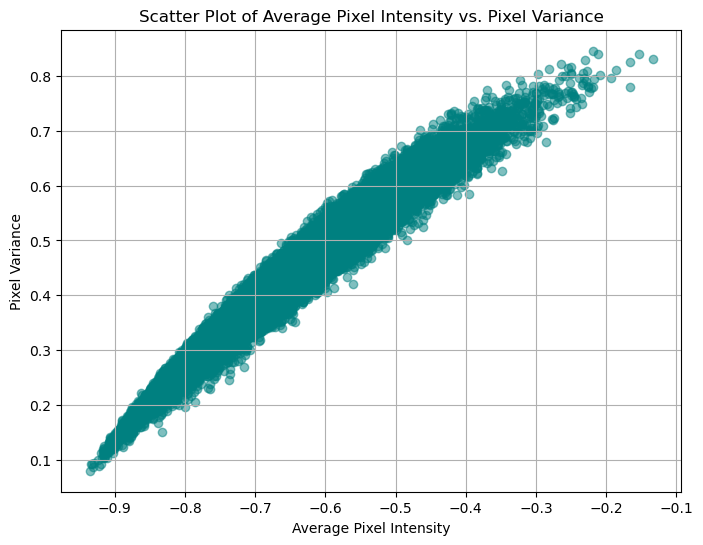

In [34]:
avg_pixel_intensities = []
pixel_variances = []

for img, _ in dataset:
    img_data = img.numpy().flatten()
    avg_pixel_intensities.append(np.mean(img_data))
    pixel_variances.append(np.var(img_data))

avg_pixel_intensities = np.array(avg_pixel_intensities)
pixel_variances = np.array(pixel_variances)

plt.figure(figsize=(8, 6))
plt.scatter(avg_pixel_intensities, pixel_variances, alpha=0.5, color='teal')
plt.title("Scatter Plot of Average Pixel Intensity vs. Pixel Variance")
plt.xlabel("Average Pixel Intensity")
plt.ylabel("Pixel Variance")
plt.grid(True)
plt.show()


## Splitting the dataset into training and testing

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=dataset.targets)

train_indices, val_indices = train_test_split(train_indices, test_size=0.2, stratify=[dataset.targets[i] for i in train_indices])

train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(test_subset)}")


Training samples: 38876
Validation samples: 9720
Test samples: 12149


## Basic CNN Architecture

## CNN Model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) 
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.fc1 = nn.Linear(128 * 3 * 3, 512) 
        self.fc2 = nn.Linear(512, 36) 
        
        # Dropout
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        
        x = x.view(-1, 128 * 3 * 3)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 

        return x

## Summary of the model

In [7]:
model = SimpleCNN()
summary(model, (1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 512]         590,336
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 36]          18,468
Total params: 701,476
Trainable params: 701,476
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 2.68
Estimated Total Size (MB): 3.10
-------------------------------------------

## Training the Model

In [8]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()  
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad() 
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total * 100)
        
        model.eval()  
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total * 100)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")
    
    time_taken = time.time() - start_time
    print(f"Training complete in {time_taken // 60}m {time_taken % 60:.0f}s")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, epochs=10)


Epoch [1/10], Train Loss: 0.6382, Train Accuracy: 78.95%, Val Loss: 0.2486, Val Accuracy: 90.93%
Epoch [2/10], Train Loss: 0.2665, Train Accuracy: 90.40%, Val Loss: 0.2128, Val Accuracy: 92.30%
Epoch [3/10], Train Loss: 0.2251, Train Accuracy: 91.85%, Val Loss: 0.1997, Val Accuracy: 92.77%
Epoch [4/10], Train Loss: 0.1990, Train Accuracy: 92.69%, Val Loss: 0.2204, Val Accuracy: 92.30%
Epoch [5/10], Train Loss: 0.1849, Train Accuracy: 92.97%, Val Loss: 0.2057, Val Accuracy: 92.56%
Epoch [6/10], Train Loss: 0.1740, Train Accuracy: 93.24%, Val Loss: 0.1988, Val Accuracy: 93.00%
Epoch [7/10], Train Loss: 0.1607, Train Accuracy: 93.66%, Val Loss: 0.2019, Val Accuracy: 93.07%
Epoch [8/10], Train Loss: 0.1486, Train Accuracy: 94.06%, Val Loss: 0.2143, Val Accuracy: 93.14%
Epoch [9/10], Train Loss: 0.1472, Train Accuracy: 94.11%, Val Loss: 0.2107, Val Accuracy: 93.07%
Epoch [10/10], Train Loss: 0.1403, Train Accuracy: 94.37%, Val Loss: 0.2203, Val Accuracy: 92.95%
Training complete in 16.0m 12

## Model1 - Data Augmentation

In [9]:
transform_augment = transforms.Compose([
    transforms.RandomResizedCrop(28),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(30),     
    transforms.ToTensor(),             
    transforms.Normalize((0.5,), (0.5,)) 
])

class CNNWithDataAugmentation(nn.Module):
    def __init__(self):
        super(CNNWithDataAugmentation, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 36)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model.train()
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        model.eval()  
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return model, train_accuracies, val_accuracies, train_losses, val_losses

model_augment = CNNWithDataAugmentation()
optimizer = optim.Adam(model_augment.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
model_augment, aug_train_accuracies, aug_val_accuracies, aug_train_losses, aug_val_losses = train_model(
    model_augment, train_loader, val_loader, optimizer, criterion, epochs=epochs
)

Epoch [1/10], Training Loss: 0.5341, Training Accuracy: 0.8250, Validation Loss: 0.2646, Validation Accuracy: 0.9069
Epoch [2/10], Training Loss: 0.2230, Training Accuracy: 0.9177, Validation Loss: 0.2158, Validation Accuracy: 0.9235
Epoch [3/10], Training Loss: 0.1818, Training Accuracy: 0.9299, Validation Loss: 0.2220, Validation Accuracy: 0.9189
Epoch [4/10], Training Loss: 0.1635, Training Accuracy: 0.9366, Validation Loss: 0.2110, Validation Accuracy: 0.9252
Epoch [5/10], Training Loss: 0.1477, Training Accuracy: 0.9411, Validation Loss: 0.2170, Validation Accuracy: 0.9274
Epoch [6/10], Training Loss: 0.1360, Training Accuracy: 0.9443, Validation Loss: 0.2239, Validation Accuracy: 0.9237
Epoch [7/10], Training Loss: 0.1265, Training Accuracy: 0.9489, Validation Loss: 0.2093, Validation Accuracy: 0.9293
Epoch [8/10], Training Loss: 0.1213, Training Accuracy: 0.9493, Validation Loss: 0.2316, Validation Accuracy: 0.9258
Epoch [9/10], Training Loss: 0.1165, Training Accuracy: 0.9515, 

## Model2: Learning Rate Scheduler

In [10]:
model_lr = SimpleCNN()

optimizer = optim.Adam(model_lr.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  

model_lr, lr_train_accuracies, lr_val_accuracies, lr_train_losses, lr_val_losses = train_model(
    model_augment, train_loader, val_loader, optimizer, criterion, epochs=epochs
)


Epoch [1/10], Training Loss: 0.1061, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [2/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [3/10], Training Loss: 0.1059, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [4/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [5/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [6/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [7/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [8/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [9/10], Training Loss: 0.1060, Training Accuracy: 0.9558, 

## Model3: Batch Normalization

In [11]:
class CNNWithBatchNormalization(nn.Module):
    def __init__(self):
        super(CNNWithBatchNormalization, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_bn = CNNWithBatchNormalization()
optimizer = optim.Adam(model_bn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_bn, bn_train_accuracies, bn_val_accuracies, bn_train_losses, bn_val_losses = train_model(
    model_augment, train_loader, val_loader, optimizer, criterion, epochs=epochs
)

Epoch [1/10], Training Loss: 0.1061, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [2/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [3/10], Training Loss: 0.1059, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [4/10], Training Loss: 0.1059, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [5/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [6/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [7/10], Training Loss: 0.1060, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [8/10], Training Loss: 0.1059, Training Accuracy: 0.9558, Validation Loss: 0.2333, Validation Accuracy: 0.9296
Epoch [9/10], Training Loss: 0.1061, Training Accuracy: 0.9558, 

## Saving the Best model

In [39]:
accuracy_augment = sum(aug_train_accuracies)/len(aug_train_accuracies)
accuracy_lr = sum(lr_train_accuracies)/len(lr_train_accuracies)
accuracy_bn = sum(bn_train_accuracies)/len(bn_train_accuracies)
if accuracy_augment > accuracy_lr and accuracy_augment > accuracy_bn:
    torch.save(model_augment.state_dict(), 'best_model.pth')
    model = model_augment
    train_accuracies = aug_train_accuracies
    val_accuracies = aug_val_accuracies
    train_losses = aug_train_losses
    val_losses = aug_val_losses
elif accuracy_lr > accuracy_augment and accuracy_lr >= accuracy_bn:
    torch.save(model_lr.state_dict(), 'best_model.pth')
    model = model_lr
    train_accuracies = lr_train_accuracies
    val_accuracies = lr_val_accuracies
    train_losses = lr_train_losses
    val_losses = lr_val_losses
else:
    torch.save(model_bn.state_dict(), 'best_model.pth')
    model = model_bn
    train_accuracies = bn_train_accuracies
    val_accuracies = bn_val_accuracies
    train_losses = bn_train_losses
    val_losses = bn_val_losses

### Best Model

In [41]:
summary(model_lr, (1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]          73,856
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Linear-7                  [-1, 512]         590,336
            Linear-8                   [-1, 36]          18,468
Total params: 701,476
Trainable params: 701,476
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 2.68
Estimated Total Size (MB): 3.10
----------------------------------------------------------------


## Evaluating the model on test data

In [13]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()  
    correct = 0
    total = 0
    running_loss = 0.0
    all_labels = []
    all_preds = []
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    end_time = time.time()
    evaluation_time = end_time - start_time
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    avg_loss = running_loss / len(test_loader)
    
    return accuracy, precision, recall, f1, avg_loss, evaluation_time, conf_matrix, fpr, tpr, roc_auc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

criterion = torch.nn.CrossEntropyLoss()

test_accuracy, precision, recall, f1, test_loss, evaluation_time, conf_matrix, fpr, tpr, roc_auc = evaluate_model(model, test_loader, criterion, device)

print(f"Evaluation Time: {evaluation_time:.4f} seconds")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Evaluation Time: 24.9368 seconds
Accuracy: 0.9318
Precision: 0.9350
Recall: 0.9318
F1 Score: 0.9308
Test Loss: 0.2178
Confusion Matrix:
[[548   0   0   0   0   0   0   0   1   0   1   1   0   9   0   0   0   0
    0   0   0   0]
 [  0 441   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
   80   0   0  37]
 [  0   0 549   0   1   0   0   2   0   1   2   1   0   0   0   0   1   0
    2   1   0   0]
 [  0   1   2 529   0   0   0   1   3   0   0  21   0   0   0   0   0   0
    0   3   0   0]
 [  1   0   0   0 549   0   0   0   1   3   2   0   1   0   0   3   0   0
    0   0   0   0]
 [  0   0   1   3   0 544   0   0   4   1   0   1   2   0   0   0   0   0
    0   4   0   0]
 [  0   1   1   0   0   0 554   0   0   0   0   1   1   0   0   0   1   0
    0   0   0   1]
 [  0   0   0   0   0   0   0 559   0   0   0   0   0   0   0   0   0   0
    1   0   0   0]
 [  0   1   0   0   1   0   0   1 546   2   1   5   0   0   1   1   0   0
    0   0   1   0]
 [  0   0   0   0   2   1  

## Visualization

### Training, Validation, and Test Accuracy

[0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564, 0.9558339335322564] 10


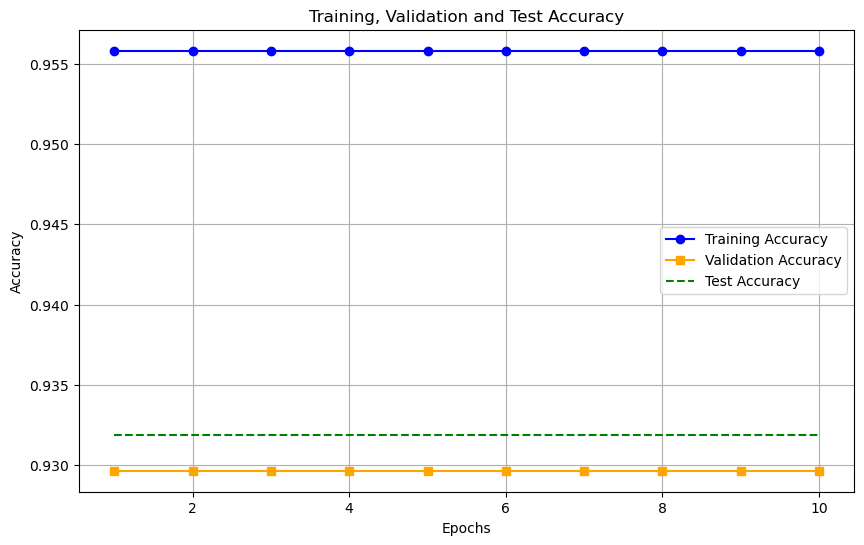

In [17]:
epochs_arr = [i for i in range(1, epochs+1)]
test_accuracies = [test_accuracy] * epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, train_accuracies, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs_arr, val_accuracies, label='Validation Accuracy', color='orange', marker='s')
plt.plot(epochs_arr, test_accuracies, label='Test Accuracy', color='green', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation and Test Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### Training, Validation, and Test Loss

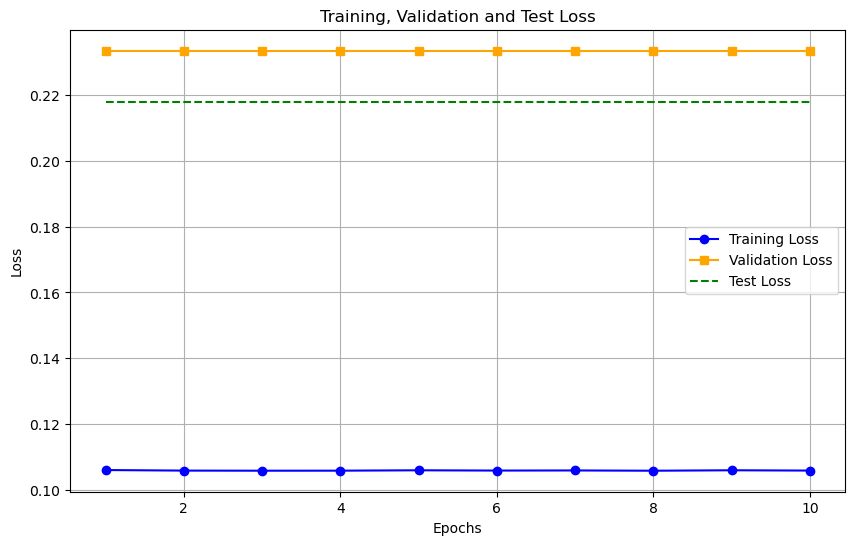

In [19]:
test_losses = [test_loss] * epochs

plt.figure(figsize=(10, 6))
plt.plot(epochs_arr, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs_arr, val_losses, label='Validation Loss', color='orange', marker='s')
plt.plot(epochs_arr, test_losses, label='Test Loss', color='green', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation and Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()


### Confusion Matrix

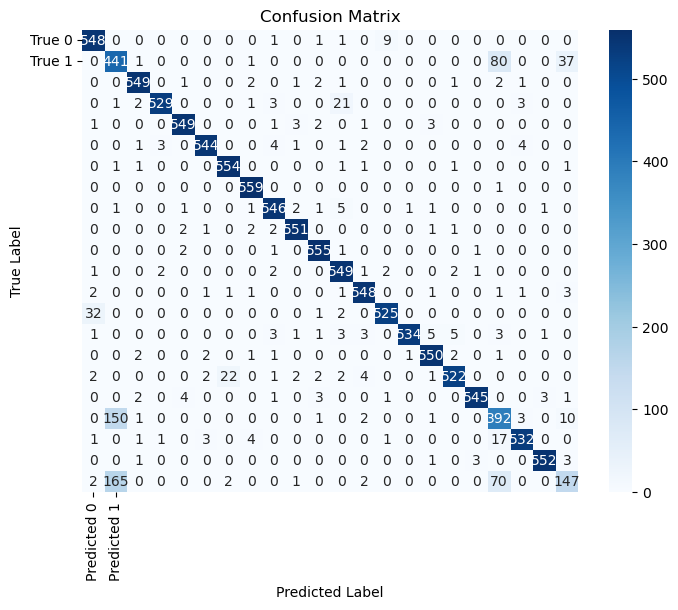

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ROC Curve

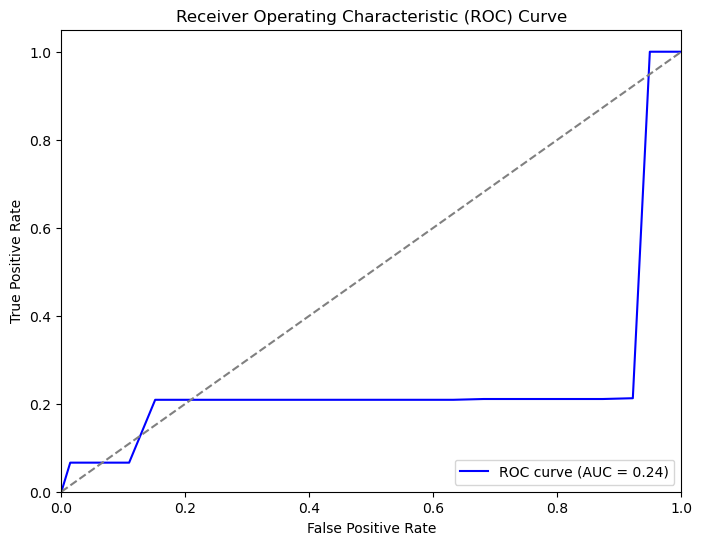

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## References
- https://pandas.pydata.org/docs/index.html
- https://matplotlib.org/stable/index.html
- https://seaborn.pydata.org/
- https://pytorch.org/tutorials/
- https://scikit-learn.org/stable/